# 

In [1]:
import sys; sys.path.append('./notebooks/')
from _load_results import *

from tqdm import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

from glob import glob

def load_results():
    results = []
    for results_path in [results_path_llms, results_path_not_llms]:
        for file in tqdm(glob(
            f"{results_path}/**/*.json",
            recursive=True,
        )):
            df = pd.read_json(file, typ="series")
    
            # unifying column name
            df = df.rename(index={"few_feature": "icd_only"})
            
            indxs = df.index
            # indxs = [indx for indx in indxs if indx not in ['pred', 'pred_proba']]
    
            if 'GPT' in file and False: # different notion of model size
                # Loading the program and counting the number of lines as a measure of interpretability
                cp_file = file.replace('.json', '_program.py') \
                        .replace(df['target'], targets_rev[df['target']])

                if 'iterative' not in file: # removing the fold from file name if not iterative
                    cp_file = cp_file.replace(f"_{df['fold']}_", '__')

                with open(cp_file, 'r') as f:
                    # Writing number of lines as size. complexity still counts the number of operations
                    df['size'] = len([l for l in f.readlines() if l.strip(' \n') != ''])

            results.append(df[indxs])
    results_df = pd.DataFrame(data=results, columns=indxs)

    # Beautifying it
    results_df["model"] = results_df["model"].apply(lambda m: nice_model_labels[m])
    results_df["target"] = results_df["target"].apply(lambda t: dnames_to_nice[t])
    
    results_df = results_df[results_df["model"].isin(order)]
    
    print(results_df.shape)
    print(results_df["model"].unique())
    print(results_df["target"].unique())
    return results_df

results_df = load_results()

%matplotlib inline

boxplot_kwargs = {
    # 'sharey':True,
    'notch':False,
    'showcaps':True,
    'flierprops':{"marker": "x"},
    'boxprops':{"facecolor": 'white'},
    'medianprops':{"color": "r", "linewidth": 2}
}

phenotypes_order =  ['HTN Heuristic', 'Htn-Hypokalemia Heuristic', 'Resistant HTN Heuristic',
                     'HTN Diagnosis', 'HTN-Hypokalemia Diagnosis', 'Resistant HTN Diagnosis']

# Making it the format seaborn likes
results_df_melted = pd.melt(
    results_df, 
    id_vars=['model', 'target', 'fold', 'RunID', 'random_state', 'prompt_richness', 'icd_only']
)

print(results_df_melted['random_state'].unique())
# display(results_df_melted.sample(3))

100%|██████████| 749/749 [00:04<00:00, 155.22it/s]


(7799, 25)
['gpt-3.5-turbo' 'gpt-3.5-turbo-iter' 'gpt-4o' 'gpt-4o-iter' 'gpt-4o-mini'
 'gpt-4o-mini-iter' 'DT' 'FEAT' 'LR L1' 'RF']
['HTN Heuristic' 'HTN Diagnosis' 'HTN-Hypokalemia Diagnosis'
 'Htn-Hypokalemia Heuristic' 'Resistant HTN Heuristic'
 'Resistant HTN Diagnosis']
[ 1318 14724 16695 24284 24481 27690 31658  6832  6933  8233]


In [2]:
# Number of results

# group by different experimental settings, count the occurence of experiments (any of
# 'fold', 'RunID', 'random_state' should do it), then pivot to fit everything in the screen

# 'prompt_richness', 'icd_only' --> these should be irrelevant, as I am loading a single setting
# (the best one from the 00 notebook analysis) for the LLMs.

results_df \
    .groupby(['model', 'target', ]) \
    .count()[['fold', 'RunID', 'random_state']] \
    .pivot_table(index=['target'], columns=['model'],values='random_state') \
    .fillna(0).astype('int').style.background_gradient(axis=None, cmap='viridis')  

model,DT,FEAT,LR L1,RF,gpt-3.5-turbo,gpt-3.5-turbo-iter,gpt-4o,gpt-4o-iter,gpt-4o-mini,gpt-4o-mini-iter
target,,,,,,,,,,
HTN Diagnosis,25,24,25,25,200,200,200,200,200,200
HTN Heuristic,25,25,25,25,200,200,200,200,200,200
HTN-Hypokalemia Diagnosis,25,25,25,25,200,200,200,200,200,200
Htn-Hypokalemia Heuristic,25,25,25,25,200,200,200,200,200,200
Resistant HTN Diagnosis,25,25,25,25,200,200,200,200,200,200
Resistant HTN Heuristic,25,25,25,25,200,200,200,200,200,200


In [3]:
results_df_melted.loc[results_df_melted['model'].isin(['DT','FEAT','LR L1','RF'])]

,model,target,fold,RunID,random_state,prompt_richness,icd_only,variable,value
7200,DT,HTN Heuristic,A,0,1318,True,False,accuracy_score_train,0.998609
7201,DT,HTN Heuristic,B,0,1318,True,False,accuracy_score_train,0.998609
7202,DT,HTN Heuristic,C,0,1318,True,False,accuracy_score_train,0.998609
7203,DT,HTN Heuristic,D,0,1318,True,False,accuracy_score_train,0.998609
7204,DT,HTN Heuristic,E,0,1318,True,False,accuracy_score_train,1.0
...,...,...,...,...,...,...,...,...,...
140377,RF,Resistant HTN Diagnosis,A,0,6933,True,False,pred_proba,"[0.514117647058823, 0.0, 0.0, 0.0, 0.104705882..."
140378,RF,Resistant HTN Diagnosis,B,0,6933,True,False,pred_proba,"[0.0, 0.59076923076923, 0.01, 0.00461538461538..."
140379,RF,Resistant HTN Diagnosis,C,0,6933,True,False,pred_proba,"[0.022222222222222, 0.002222222222222, 0.07777..."
140380,RF,Resistant HTN Diagnosis,D,0,6933,True,False,pred_proba,"[1.6313213703099512e-05, 1.6313213703099512e-0..."


prompt_richness True expert_features True


/tmp/ipykernel_791296/1748485556.py:52: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gpt-4o-mini_Zero Shot vs. gpt-4o-mini_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.104e-04 U_stat=7.120e+02
gpt-4o_Zero Shot vs. gpt-4o_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.741e-03 U_stat=8.150e+02
gpt-4o_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.958e-12 U_stat=0.000e+00
gpt-4o-mini_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.958e-12 U_stat=0.000e+00
gpt-3.5-turbo_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.916e-12 U_stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e

/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecat

saving ../paper_rebuttal/bar_AUPRC_stat_comparisons_True_True.pdf


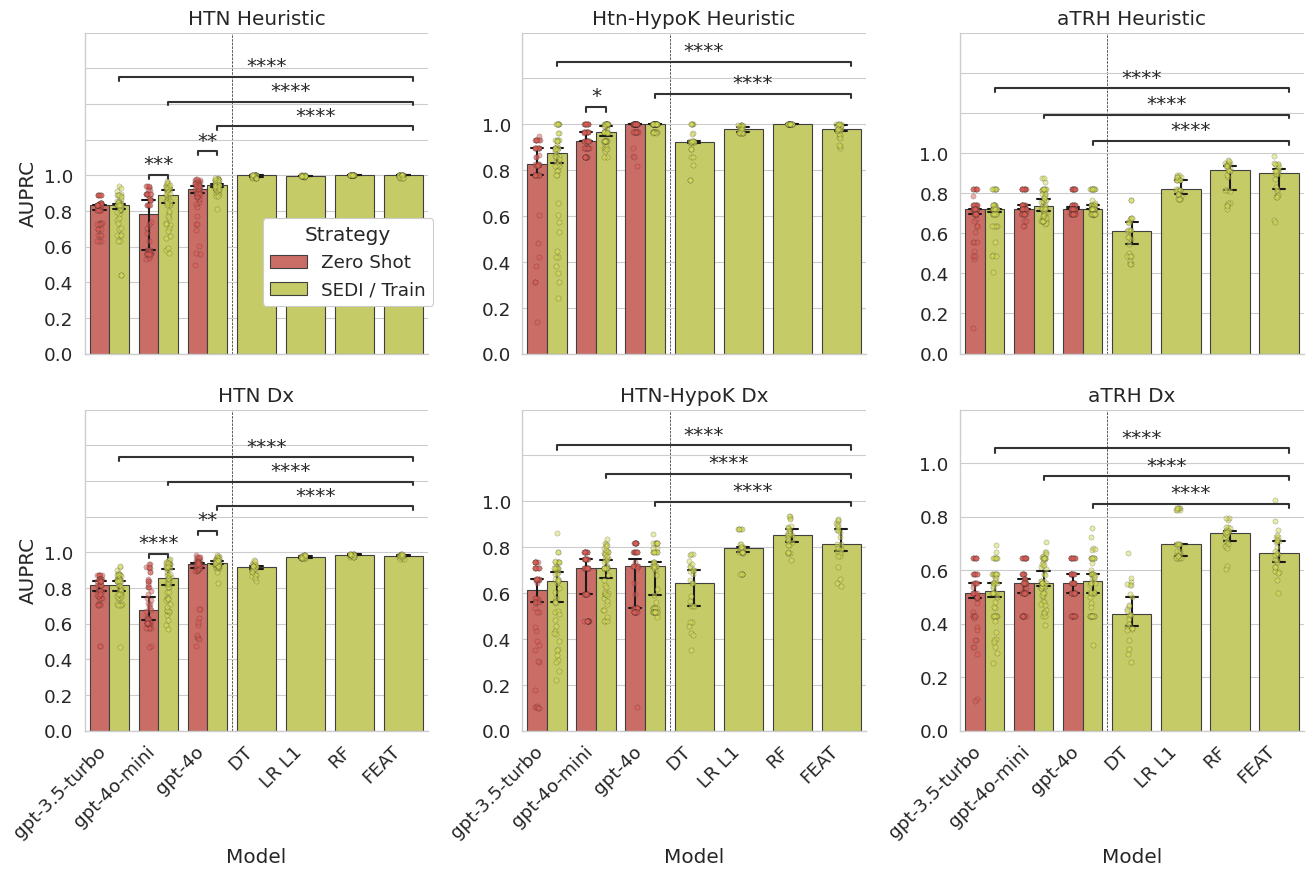

prompt_richness True expert_features False


/tmp/ipykernel_791296/1748485556.py:52: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gpt-4o_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.905e-05 U_stat=2.605e+02
gpt-4o-mini_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.530e-07 U_stat=1.600e+02
gpt-3.5-turbo_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.372e-05 U_stat=2.375e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gpt-4o-mini_Zero Shot vs. gpt-4o-mini_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:4.617e-07 U_stat=5.220e+02
gpt-4o_Zero

/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecat

saving ../paper_rebuttal/bar_AUPRC_stat_comparisons_True_False.pdf


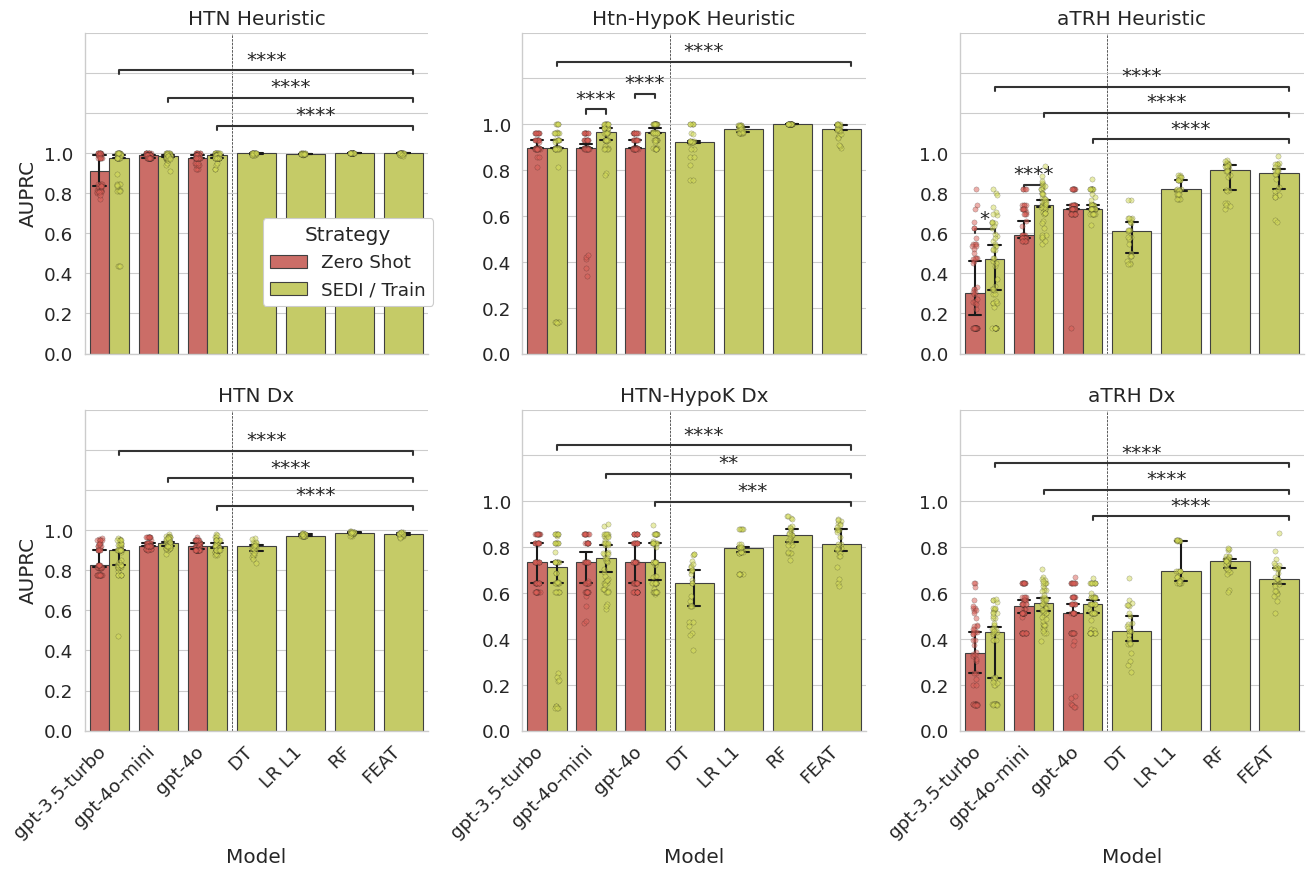

prompt_richness False expert_features True


/tmp/ipykernel_791296/1748485556.py:52: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gpt-4o_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.955e-12 U_stat=0.000e+00
gpt-4o-mini_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.699e-12 U_stat=4.000e+00
gpt-3.5-turbo_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.187e-13 U_stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gpt-4o-mini_Zero Shot vs. gpt-4o-mini_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.897e-10 U_stat=2.440e+02
gpt-4o_Zero

/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecat

saving ../paper_rebuttal/bar_AUPRC_stat_comparisons_False_True.pdf


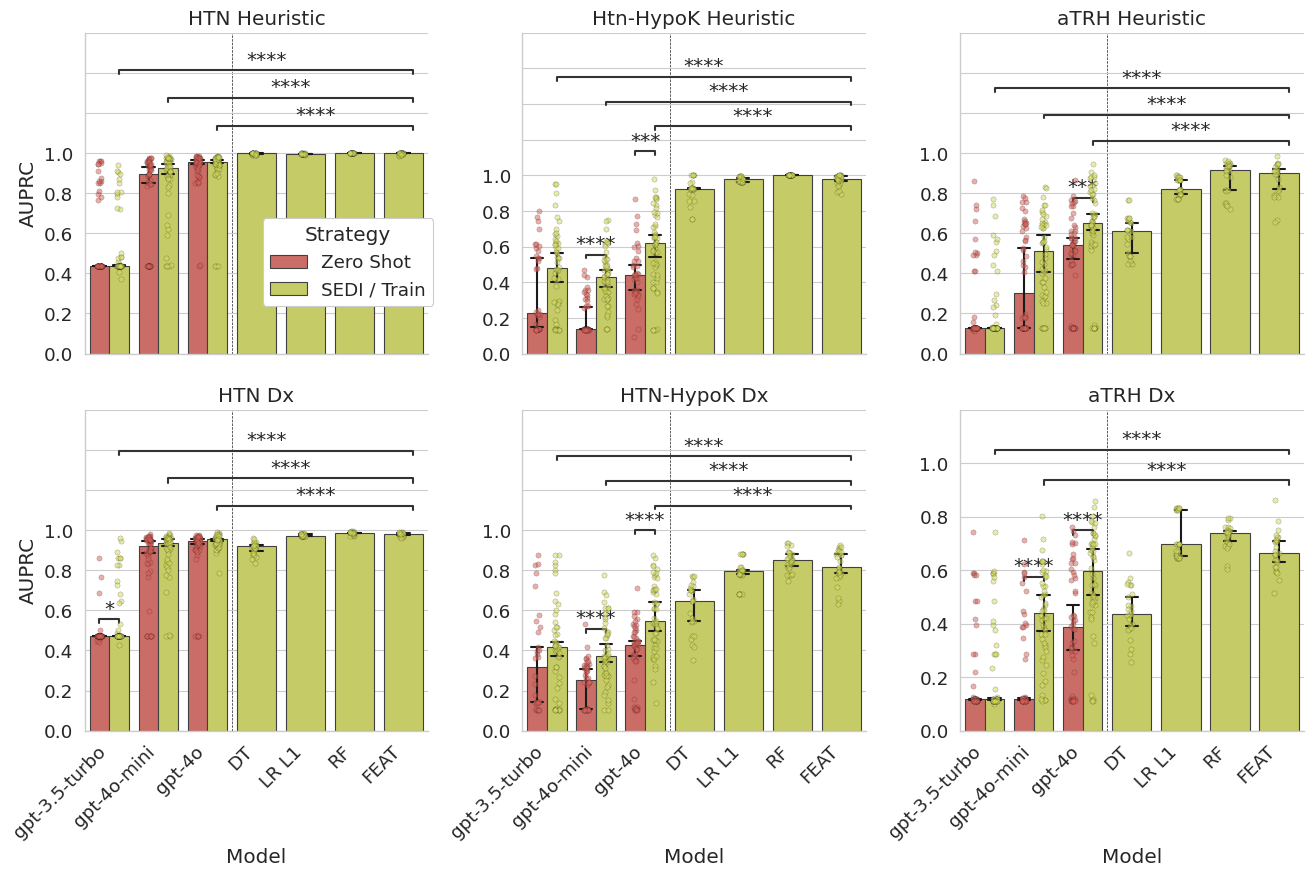

prompt_richness False expert_features False


/tmp/ipykernel_791296/1748485556.py:52: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gpt-4o_Zero Shot vs. gpt-4o_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.231e-06 U_stat=6.010e+02
gpt-4o_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.644e-12 U_stat=8.000e+00
gpt-4o-mini_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.683e-12 U_stat=4.000e+00
gpt-3.5-turbo_SEDI / Train vs. FEAT_SEDI / Train: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.935e-14 U_stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gpt-4o-mini_Zero Shot

/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ch246537/.conda/envs/htn-cp-llm/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecat

saving ../paper_rebuttal/bar_AUPRC_stat_comparisons_False_False.pdf


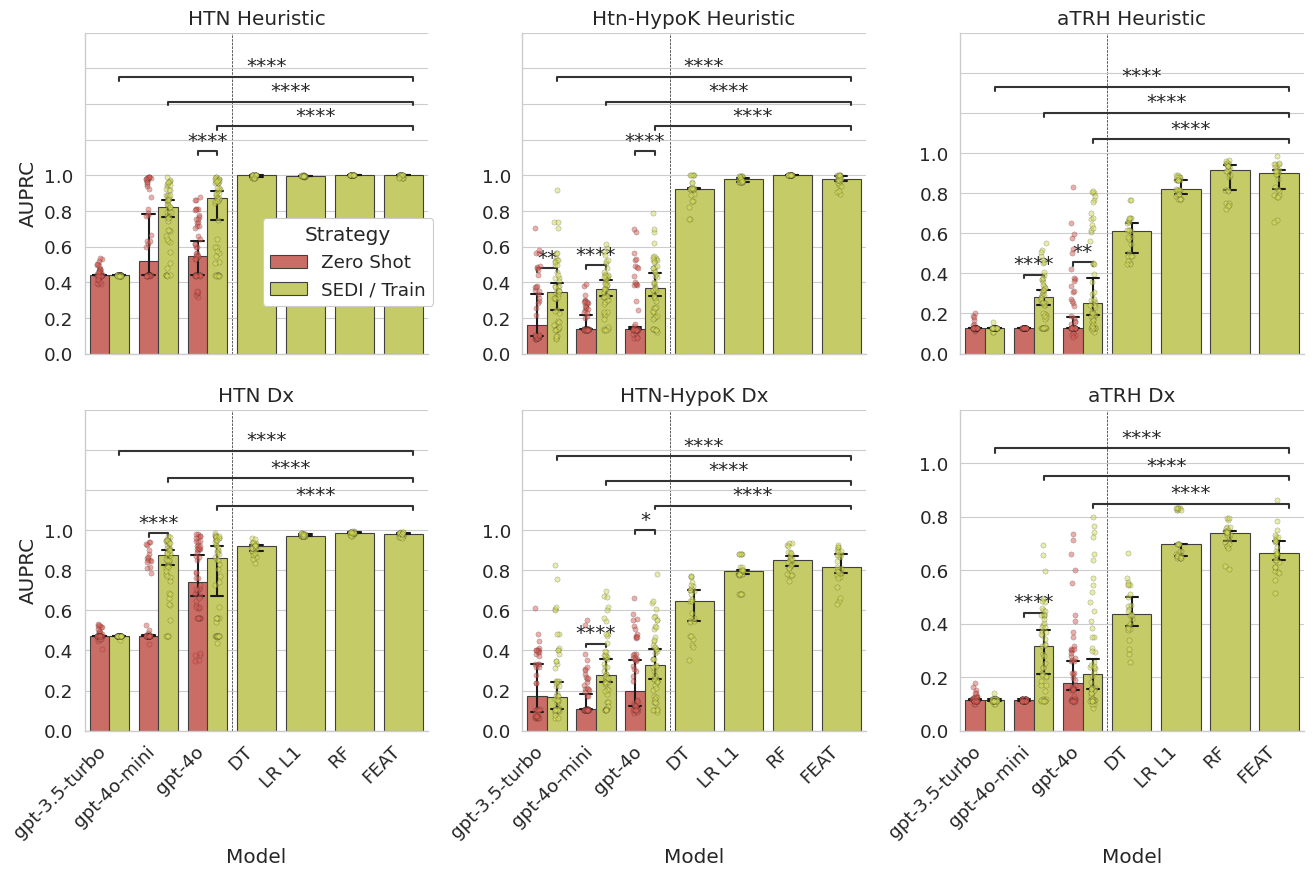

In [41]:
# Copying Fig.2 from paper "A flexible symbolic regression method for constructing
# interpretable clinical prediction models"
palette = sns.color_palette("hls", 6) # ['#374aa3', '#cc6666', '#6688d0', '#ffcccc', '#336699', '#99ccff']
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.5
)
prompt_richness=True
icd_only=True
stat_comparisons=True
for prompt_richness in [True,False]:
    for icd_only in [True,False]:
        print("prompt_richness",prompt_richness,"expert_features",icd_only)
# for stat_comparisons in [True]:
        for metric in [
            'average_precision_score_test', 
            # 'roc_auc_score_test', 
            # 'accuracy_score_test', 
            # 'size'
        ]:
            data = (
                results_df_melted[
                    (results_df_melted['variable']==metric)
                    & (
                        (results_df_melted['model'].isin(['DT','FEAT','LR L1','RF']))
                        | 
                        (
                            (results_df_melted['prompt_richness']==prompt_richness)
                            & (results_df_melted['icd_only']==icd_only)
                        )
                    )
                ]
                .dropna()
            )
            
            metric = metric.replace('average_precision_score_test', 'AUPRC') 
    
            data = data.rename(columns={'value': metric}) #, 'model':'Model'})
            data[metric] = data[metric].astype(float)
            data['Model'] = data['model'].apply(lambda x: x.replace('-iter',''))
            data['Strategy'] = ['SEDI / Train' if 'iter' in v or 'gpt' not in v else 'Zero Shot' for v in data['model'].values]
            hue_order = ['Zero Shot', 'SEDI / Train']
            
            # print(data.random_state.unique())
            # display(data)
            # # reporting the best for each fold to avoid overflooding the figure
            # data = data.groupby([c for c in data.columns if c not in ['fold', metric]])\
            #                   [metric].median().reset_index()
    
            new_order=[o for o in order if o in data['Model'].unique()]
            g = sns.catplot(
                data=data,
                x="Model", 
                order=new_order, 
                y=metric, 
                col="target",
                col_wrap=3, 
                col_order=phenotypes_order,
                aspect= 1 if stat_comparisons else 0.825,
                height= 4.5 if stat_comparisons else 3.25,
                estimator=np.median, 
                sharey=not stat_comparisons,
                hue='Strategy',
                hue_order=hue_order,
                # kind="box", 
                # **boxplot_kwargs
                kind='bar',
                # dodge=True, 
                capsize=.5,
                err_kws={"color": "k", "linewidth": 1.5},
                edgecolor=".25",
                palette=palette
            )
            # g.set_ylabels(metric.replace('_', ' ').replace(' test','').title())
            g.set_ylabels(metric.replace('_', ' ').replace(' test',''))
            # g.refline(x=2.5, color='k', lw=0.5, ls='--', zorder=0)
            
            for (title, ax) in g._axes_dict.items():
                
                # ax.plot([2.5,2.5], [0, 1.0], '--k', zorder=0, lw=0.5) #color='k', lw=0.5, ls='--', zorder=0)
                ax.axvline(2.5, ls='--', c='k', zorder=0, lw=0.5) #color='k', lw=0.5, ls='--', zorder=0)
                
                # ax.set_title(title)
                ax.set_title(
                    title
                    .replace('Diagnosis','Dx')
                    .replace('Resistant HTN', 'aTRH')
                    .replace('Hypokalemia','HypoK')
                )
                ax.grid(which='major', axis='y', linewidth=.8)
                ax.grid(which='major', axis='x', linewidth=.5)
                
                for tick in ax.get_xticklabels():            
                    if stat_comparisons:
                        tick.set(rotation=45, ha='right', va='top', ma='center')
                    else:
                        tick.set(rotation=90, ha='center', va='top', ma='center')
                # yticks,yticklabels =  zip(*[
                #          (yt,yl) for yt,yl in zip(ax.get_yticks(),ax.get_yticklabels()) if yl not in ['1.1','1.2']
                # ])
                # ax.set_yticks(yticks, yticklabels)
                # ax.set_yticks(yticks)
                if metric=='Size':
                    ax.set_yscale('log')
                elif 'roc' in metric.lower():
                    ax.set_ylim(bottom=0.5)
                # Loop over the bars
                for i,(thisbar, thisline) in enumerate(zip(ax.patches,ax.lines)):
                    # Set a different hatch for each bar
                    # thisbar.set_hatch(hatches[i])
                    if i > 5:
                        w = thisbar.get_width()
                        thisbar.set_x(thisbar.get_x()-w)
                        thisbar.set_width(w*2)
                        thisline.set_xdata([x-w/2 for x in thisline.get_xdata()])
                        # import pdb
                        # pdb.set_trace()
    
                # All vs baseline
                llms = [m for m in data['Model'].unique() if 'gpt' in m]
                # llms = [
                #     'gpt-4o-mini',
                #     'gpt-4o-mini-iter',
                #     'gpt-4o',
                #     'gpt-4o-iter',
                #     'gpt-4-turbo',
                #     'gpt-4-turbo-iter',
                # ]
                pairs = (
                    # list(itertools.product(llms, llms)) +
                    [((llm,'SEDI / Train'), ('FEAT','SEDI / Train')) for llm in llms ]
                    + 
                    [((llm,'SEDI / Train'), (llm,'Zero Shot')) for llm in llms ]
                )
    
                # ax.set_ylim(top=1.4)
                if stat_comparisons:
                    try:
                        annotator = Annotator(
                            ax,
                            pairs, 
                            data=data[(data['target']==title)], #[ ['Model', 'target',	metric, 'Strategy'] ],
                            x='Model', y=metric,
                            order=new_order,
                            hue='Strategy',
                            hue_order=hue_order,
                        )
                        annotator.reset_configuration()
                        annotator.configure(
                            test="Mann-Whitney", 
                            hide_non_significant=True, 
                            # text_format='simple',
                            text_format='star',
                            comparisons_correction="holm", 
                            verbose=1
                        ) # , text_offset=-3
                        
                        # Calculate and annotate
                        annotator.apply_and_annotate()
                    except Exception as e:
                        print(f"failed to add statsannotation with dataset {title}. Except {e}")
    
                    yticklabels = ax.get_yticklabels()
                    yticklabels = [yl if float(yl._text) < 1.001 else '' for yl in yticklabels]
                    ax.set_yticks(ax.get_yticks(),labels=yticklabels)
    
            
            # ------------------------------------------------------------------
            # Add stripplot overlay after creating the bar plot.

            g.map_dataframe(sns.stripplot, 
                            data=data,
                            x="Model", 
                            y=metric,
                            hue='Strategy',
                            order=new_order,
                            hue_order=hue_order,
                            dodge=True,
                            size=3.75,
                            #color='k',
                            linewidth=0.25,
                            alpha=0.5,
                            jitter=True)

            for (title, ax) in g._axes_dict.items():
                # Adjust colors and positions for the last 4 bars
                for i, point in enumerate(ax.collections):
                    offsets = point.get_offsets()

                    # not proud of this
                    if len(offsets)>0:
                        point.set_facecolors(palette[1])
                        # point.set_edgecolor(palette[1])
                        point.set_edgecolor('k')

                        if offsets[0, 0] <= 2.5: # it belongs to the small bar pairs
                            for red_low, red_up in [(-0.5, 0.0), (0.5, 1.0), (1.5, 2.0)]:
                                if red_low <= offsets[0, 0] <= red_up:
                                    point.set_facecolors(palette[0])
                                    # point.set_edgecolor(palette[0])
                        else: # other ML methods
                            # Shift points left by 0.25 units and increase spread
                            offsets[:, 0] -= 0.25  # Modify x-coordinates

                            # Update scatter plot positions
                            point.set_offsets(offsets)
            # ------------------------------------------------------------------

            # Adjust legend position to accommodate stripplot points
            sns.move_legend(g, loc=[.2,.65] if stat_comparisons else [0.2,0.7], frameon=True, framealpha=1)

            # plt.tight_layout()

            sns.move_legend(g,loc=[.2,.65] if stat_comparisons else [0.2,0.7],frameon=True, framealpha=1)
            figname = (
                f"{paper_dir}/bar_{metric}{'_stat_comparisons' if stat_comparisons else ''}_{prompt_richness}_{icd_only}.pdf"
            )
            print('saving',figname)
            
            plt.savefig(figname, bbox_inches='tight' )
            # plt.savefig(f"{paper_dir}/bar_{metric}{'_stat_comparisons' if stat_comparisons else ''}.png")
            plt.show()

In [5]:
yaxis_metrics = ['average_precision_score_test', 'roc_auc_score_test', 'accuracy_score_test']
phenotypes = ['Diagnosis', 'Heuristic']

for target in results_df_melted['target'].unique():
    print(target)

    data = results_df_melted[ 
        ( results_df_melted['variable'].isin(yaxis_metrics) )
        & ( results_df_melted['target'].str.contains(target) ) ]

    # Aggregate data
    aggregated_data = data.groupby(['model', 'variable'])['value'].agg(['mean', 'std']).reset_index()
    
    # Pivot the data
    pivoted_data = aggregated_data.pivot(index='model', columns=['variable'], values=['mean', 'std']).fillna(0)
    
    # Flatten column names
    pivoted_data.columns = [f"{col[0]}_{col[1]}" for col in pivoted_data.columns]
    
    # display(pivoted_data)
    
    # Create a new DataFrame with mean ± std format
    formatted_data = pd.DataFrame({
        yaxis: pivoted_data[f"mean_{yaxis}"].astype(str) + r'\pm' + pivoted_data[f"std_{yaxis}"].astype(str)
        for yaxis in yaxis_metrics
    }, index=pivoted_data.index)
    
    # Format the values to two decimal places
    formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")
    
    display(formatted_data)
    
    # Create LaTeX table
    latex_table = formatted_data.to_latex(
        index=True,
        # caption=f"{yaxis.capitalize().replace('_', ' ')} scores for {target} models",
        # label=f"tab:{target.lower()}_{yaxis.replace('_', '')}",
        position="htbp",
        column_format="lrrr",
        escape=False
    )
    
    # Save LaTeX table to file
    filename = f"{paper_dir}/tab_{target.lower().replace(' ','-')}.tex"
    with open(filename, 'w') as f:
        f.write(latex_table)
    
    print(f"\nLaTeX table saved to {filename}\n")

HTN Heuristic


<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_791296/660274558.py:29: SyntaxWarning: invalid escape sequence '\p'
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")
/tmp/ipykernel_791296/660274558.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = aggregated_data.pivot(index='model', columns=['variable'], values=['mean', 'std']).fillna(0)
/tmp/ipykernel_791296/660274558.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")


,average_precision_score_test,roc_auc_score_test,accuracy_score_test
model,,,
DT,$0.79 \pm 0.22$,$0.93 \pm 0.08$,$0.96 \pm 0.04$
FEAT,$0.93 \pm 0.09$,$0.98 \pm 0.03$,$0.97 \pm 0.03$
LR L1,$0.91 \pm 0.09$,$0.98 \pm 0.03$,$0.95 \pm 0.02$
RF,$0.94 \pm 0.08$,$0.99 \pm 0.01$,$0.97 \pm 0.03$
gpt-3.5-turbo,$0.51 \pm 0.29$,$0.71 \pm 0.21$,$0.77 \pm 0.18$
gpt-3.5-turbo-iter,$0.52 \pm 0.29$,$0.72 \pm 0.21$,$0.79 \pm 0.18$
gpt-4o,$0.69 \pm 0.27$,$0.85 \pm 0.20$,$0.76 \pm 0.25$
gpt-4o-iter,$0.76 \pm 0.24$,$0.90 \pm 0.16$,$0.77 \pm 0.25$
gpt-4o-mini,$0.63 \pm 0.29$,$0.81 \pm 0.21$,$0.73 \pm 0.29$



LaTeX table saved to ../paper_rebuttal/tab_htn-heuristic.tex

HTN Diagnosis


/tmp/ipykernel_791296/660274558.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = aggregated_data.pivot(index='model', columns=['variable'], values=['mean', 'std']).fillna(0)
/tmp/ipykernel_791296/660274558.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")


,average_precision_score_test,roc_auc_score_test,accuracy_score_test
model,,,
DT,$0.68 \pm 0.25$,$0.87 \pm 0.09$,$0.91 \pm 0.02$
FEAT,$0.82 \pm 0.17$,$0.96 \pm 0.03$,$0.93 \pm 0.02$
LR L1,$0.85 \pm 0.14$,$0.96 \pm 0.02$,$0.92 \pm 0.02$
RF,$0.86 \pm 0.13$,$0.97 \pm 0.02$,$0.94 \pm 0.01$
gpt-3.5-turbo,$0.47 \pm 0.26$,$0.68 \pm 0.19$,$0.77 \pm 0.17$
gpt-3.5-turbo-iter,$0.49 \pm 0.27$,$0.70 \pm 0.19$,$0.77 \pm 0.18$
gpt-4o,$0.63 \pm 0.28$,$0.83 \pm 0.17$,$0.72 \pm 0.25$
gpt-4o-iter,$0.69 \pm 0.26$,$0.87 \pm 0.15$,$0.76 \pm 0.22$
gpt-4o-mini,$0.56 \pm 0.29$,$0.77 \pm 0.19$,$0.70 \pm 0.28$



LaTeX table saved to ../paper_rebuttal/tab_htn-diagnosis.tex

HTN-Hypokalemia Diagnosis


/tmp/ipykernel_791296/660274558.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = aggregated_data.pivot(index='model', columns=['variable'], values=['mean', 'std']).fillna(0)
/tmp/ipykernel_791296/660274558.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")


,average_precision_score_test,roc_auc_score_test,accuracy_score_test
model,,,
DT,$0.61 \pm 0.13$,$0.87 \pm 0.08$,$0.94 \pm 0.01$
FEAT,$0.82 \pm 0.09$,$0.96 \pm 0.03$,$0.95 \pm 0.01$
LR L1,$0.79 \pm 0.06$,$0.92 \pm 0.05$,$0.95 \pm 0.01$
RF,$0.85 \pm 0.05$,$0.98 \pm 0.01$,$0.95 \pm 0.01$
gpt-3.5-turbo,$0.49 \pm 0.26$,$0.78 \pm 0.22$,$0.81 \pm 0.27$
gpt-3.5-turbo-iter,$0.47 \pm 0.26$,$0.79 \pm 0.18$,$0.80 \pm 0.27$
gpt-4o,$0.51 \pm 0.24$,$0.84 \pm 0.16$,$0.76 \pm 0.32$
gpt-4o-iter,$0.58 \pm 0.21$,$0.89 \pm 0.11$,$0.85 \pm 0.22$
gpt-4o-mini,$0.46 \pm 0.27$,$0.80 \pm 0.18$,$0.70 \pm 0.35$



LaTeX table saved to ../paper_rebuttal/tab_htn-hypokalemia-diagnosis.tex

Htn-Hypokalemia Heuristic


/tmp/ipykernel_791296/660274558.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = aggregated_data.pivot(index='model', columns=['variable'], values=['mean', 'std']).fillna(0)
/tmp/ipykernel_791296/660274558.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")


,average_precision_score_test,roc_auc_score_test,accuracy_score_test
model,,,
DT,$0.92 \pm 0.07$,$0.97 \pm 0.03$,$0.99 \pm 0.01$
FEAT,$0.97 \pm 0.03$,$0.99 \pm 0.02$,$0.99 \pm 0.01$
LR L1,$0.98 \pm 0.01$,$0.99 \pm 0.01$,$0.98 \pm 0.01$
RF,$1.00 \pm 0.00$,$1.00 \pm 0.00$,$0.99 \pm 0.01$
gpt-3.5-turbo,$0.61 \pm 0.33$,$0.78 \pm 0.24$,$0.74 \pm 0.32$
gpt-3.5-turbo-iter,$0.61 \pm 0.31$,$0.81 \pm 0.19$,$0.78 \pm 0.29$
gpt-4o,$0.66 \pm 0.34$,$0.84 \pm 0.20$,$0.83 \pm 0.27$
gpt-4o-iter,$0.73 \pm 0.29$,$0.90 \pm 0.13$,$0.87 \pm 0.22$
gpt-4o-mini,$0.57 \pm 0.37$,$0.78 \pm 0.20$,$0.70 \pm 0.36$



LaTeX table saved to ../paper_rebuttal/tab_htn-hypokalemia-heuristic.tex

Resistant HTN Heuristic


/tmp/ipykernel_791296/660274558.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = aggregated_data.pivot(index='model', columns=['variable'], values=['mean', 'std']).fillna(0)
/tmp/ipykernel_791296/660274558.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")


,average_precision_score_test,roc_auc_score_test,accuracy_score_test
model,,,
DT,$0.59 \pm 0.10$,$0.86 \pm 0.05$,$0.93 \pm 0.02$
FEAT,$0.87 \pm 0.09$,$0.97 \pm 0.03$,$0.95 \pm 0.02$
LR L1,$0.83 \pm 0.04$,$0.96 \pm 0.02$,$0.94 \pm 0.00$
RF,$0.88 \pm 0.08$,$0.98 \pm 0.01$,$0.95 \pm 0.02$
gpt-3.5-turbo,$0.35 \pm 0.26$,$0.69 \pm 0.21$,$0.83 \pm 0.16$
gpt-3.5-turbo-iter,$0.37 \pm 0.27$,$0.72 \pm 0.21$,$0.85 \pm 0.15$
gpt-4o,$0.54 \pm 0.26$,$0.83 \pm 0.21$,$0.78 \pm 0.29$
gpt-4o-iter,$0.61 \pm 0.23$,$0.87 \pm 0.18$,$0.77 \pm 0.30$
gpt-4o-mini,$0.47 \pm 0.27$,$0.79 \pm 0.22$,$0.70 \pm 0.36$



LaTeX table saved to ../paper_rebuttal/tab_resistant-htn-heuristic.tex

Resistant HTN Diagnosis


/tmp/ipykernel_791296/660274558.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = aggregated_data.pivot(index='model', columns=['variable'], values=['mean', 'std']).fillna(0)
/tmp/ipykernel_791296/660274558.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")


,average_precision_score_test,roc_auc_score_test,accuracy_score_test
model,,,
DT,$0.44 \pm 0.10$,$0.79 \pm 0.07$,$0.90 \pm 0.02$
FEAT,$0.67 \pm 0.08$,$0.94 \pm 0.03$,$0.92 \pm 0.01$
LR L1,$0.72 \pm 0.08$,$0.94 \pm 0.02$,$0.92 \pm 0.02$
RF,$0.73 \pm 0.05$,$0.96 \pm 0.02$,$0.93 \pm 0.01$
gpt-3.5-turbo,$0.29 \pm 0.20$,$0.67 \pm 0.19$,$0.84 \pm 0.14$
gpt-3.5-turbo-iter,$0.30 \pm 0.20$,$0.69 \pm 0.19$,$0.84 \pm 0.16$
gpt-4o,$0.42 \pm 0.20$,$0.79 \pm 0.18$,$0.70 \pm 0.31$
gpt-4o-iter,$0.49 \pm 0.19$,$0.84 \pm 0.16$,$0.76 \pm 0.26$
gpt-4o-mini,$0.36 \pm 0.22$,$0.73 \pm 0.20$,$0.66 \pm 0.36$



LaTeX table saved to ../paper_rebuttal/tab_resistant-htn-diagnosis.tex



In [6]:
yaxis = 'roc_auc_score_test' # 'average_precision_score_test' 'accuracy_score_test'

for phenotype in ['Heuristic', 'Diagnosis']:
    print(phenotype)

    data = results_df_melted[ 
        ( results_df_melted['variable']==yaxis )
        & ( results_df_melted['target'].str.contains(phenotype) ) ]

    # Aggregate data
    aggregated_data = data.groupby(['model', 'target'])['value'].agg(['mean', 'std']).reset_index()
    
    # Pivot the data
    pivoted_data = aggregated_data.pivot(index='model', columns=['target'], values=['mean', 'std']).fillna(0)
    
    # Flatten column names
    pivoted_data.columns = [f"{col[0]}_{col[1]}" for col in pivoted_data.columns]
    
    # display(pivoted_data)
    # print(data['target'].unique())
    
    # Create a new DataFrame with mean ± std format
    formatted_data = pd.DataFrame({
        t: pivoted_data[f"mean_{t}"].astype(str) + r'\pm' + pivoted_data[f"std_{t}"].astype(str)
        for t in [p for p in phenotypes_order if p in data['target'].unique()]
    }, index=pivoted_data.index)

    # Format the values to two decimal places
    formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")
    
    display(formatted_data)
    
    # Create LaTeX table
    latex_table = formatted_data.to_latex(
        index=True,
        caption=f"{yaxis.capitalize().replace('_', ' ')} scores for {phenotype} targets",
        label=f"tab:{target.lower()}_{yaxis.replace('_', '')}",
        position="htbp",
        column_format="lrrr",
        escape=False
    )
    
    # Save LaTeX table to file
    filename = f"{paper_dir}/tab_{phenotype}.tex"
    with open(filename, 'w') as f:
        f.write(latex_table)
    
    print(f"\nLaTeX table saved to {filename}\n")

Heuristic


<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_791296/1074526869.py:29: SyntaxWarning: invalid escape sequence '\p'
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")
/tmp/ipykernel_791296/1074526869.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = aggregated_data.pivot(index='model', columns=['target'], values=['mean', 'std']).fillna(0)
/tmp/ipykernel_791296/1074526869.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")


,HTN Heuristic,Htn-Hypokalemia Heuristic,Resistant HTN Heuristic
model,,,
DT,$1.00 \pm 0.00$,$0.97 \pm 0.03$,$0.86 \pm 0.05$
FEAT,$1.00 \pm 0.00$,$0.99 \pm 0.02$,$0.97 \pm 0.03$
LR L1,$1.00 \pm 0.00$,$0.99 \pm 0.01$,$0.96 \pm 0.02$
RF,$1.00 \pm 0.00$,$1.00 \pm 0.00$,$0.98 \pm 0.01$
gpt-3.5-turbo,$0.73 \pm 0.20$,$0.78 \pm 0.24$,$0.69 \pm 0.21$
gpt-3.5-turbo-iter,$0.72 \pm 0.21$,$0.81 \pm 0.19$,$0.72 \pm 0.21$
gpt-4o,$0.87 \pm 0.17$,$0.84 \pm 0.20$,$0.83 \pm 0.21$
gpt-4o-iter,$0.92 \pm 0.13$,$0.90 \pm 0.13$,$0.87 \pm 0.18$
gpt-4o-mini,$0.83 \pm 0.19$,$0.78 \pm 0.20$,$0.79 \pm 0.22$



LaTeX table saved to ../paper_rebuttal/tab_Heuristic.tex

Diagnosis


/tmp/ipykernel_791296/1074526869.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivoted_data = aggregated_data.pivot(index='model', columns=['target'], values=['mean', 'std']).fillna(0)
/tmp/ipykernel_791296/1074526869.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = formatted_data.applymap(lambda x: f"${float(x.split(r'\pm')[0]):.2f} \pm {float(x.split(r'\pm')[1]):.2f}$")


,HTN Diagnosis,HTN-Hypokalemia Diagnosis,Resistant HTN Diagnosis
model,,,
DT,$0.94 \pm 0.02$,$0.87 \pm 0.08$,$0.79 \pm 0.07$
FEAT,$0.98 \pm 0.01$,$0.96 \pm 0.03$,$0.94 \pm 0.03$
LR L1,$0.98 \pm 0.00$,$0.92 \pm 0.05$,$0.94 \pm 0.02$
RF,$0.99 \pm 0.00$,$0.98 \pm 0.01$,$0.96 \pm 0.02$
gpt-3.5-turbo,$0.68 \pm 0.18$,$0.78 \pm 0.22$,$0.67 \pm 0.19$
gpt-3.5-turbo-iter,$0.70 \pm 0.19$,$0.79 \pm 0.18$,$0.69 \pm 0.19$
gpt-4o,$0.88 \pm 0.15$,$0.84 \pm 0.16$,$0.79 \pm 0.18$
gpt-4o-iter,$0.91 \pm 0.12$,$0.89 \pm 0.11$,$0.84 \pm 0.16$
gpt-4o-mini,$0.80 \pm 0.18$,$0.80 \pm 0.18$,$0.73 \pm 0.20$



LaTeX table saved to ../paper_rebuttal/tab_Diagnosis.tex



['gpt-3.5-turbo-iter' 'gpt-4o-iter' 'gpt-4o-mini-iter' 'DT' 'FEAT' 'LR L1'
 'RF']
Index(['target', 'Model', 'Average precision score testmean',
       'Average precision score teststd',
       'Average precision score testlower_ci',
       'Average precision score testupper_ci', 'Sizemean', 'Sizestd',
       'Sizelower_ci', 'Sizeupper_ci'],
      dtype='object')


/tmp/ipykernel_791296/1805252736.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]


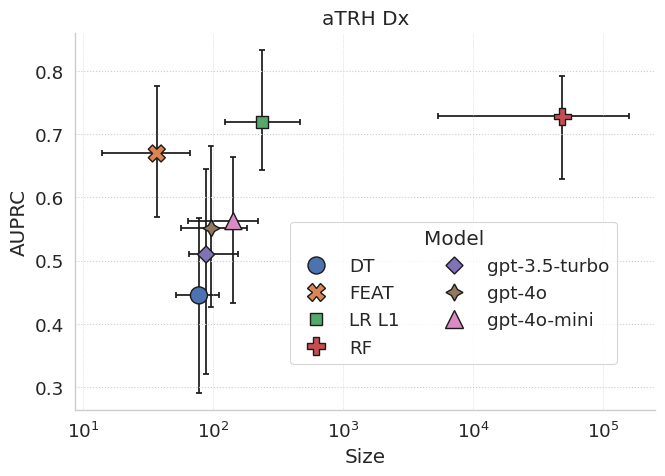

['gpt-3.5-turbo-iter' 'gpt-4o-iter' 'gpt-4o-mini-iter' 'DT' 'FEAT' 'LR L1'
 'RF']
Index(['target', 'Model', 'Roc auc score testmean', 'Roc auc score teststd',
       'Roc auc score testlower_ci', 'Roc auc score testupper_ci', 'Sizemean',
       'Sizestd', 'Sizelower_ci', 'Sizeupper_ci'],
      dtype='object')


/tmp/ipykernel_791296/1805252736.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]


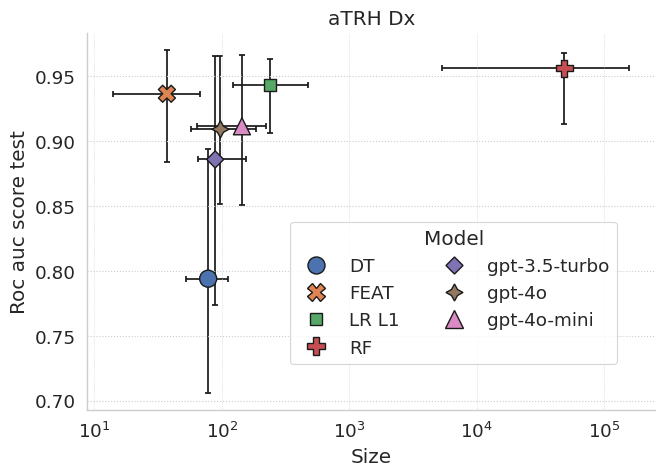

In [7]:
# Copying Fig.3 from paper "A flexible symbolic regression method for constructing
# interpretable clinical prediction models"

palette = sns.color_palette("hls", 7) # ['#374aa3', '#cc6666', '#6688d0', '#ffcccc', '#336699', '#99ccff']
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.5
)

for yaxis in ['average_precision_score_test', 'roc_auc_score_test']:
    data = (
        results_df[
            (results_df['model'].isin(['DT','FEAT','LR L1','RF']))
            | 
            (
                (results_df['prompt_richness']==True)
                & ( (results_df['icd_only']==True)
                  & (results_df['model'].str.contains('iter')))
            )
        ]
    )

    print(data.model.unique())
    data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]
    #data = data[data['Strategy']=='SEDI']

    data = data.rename(columns={yaxis: yaxis.replace('_', ' ').capitalize(), 'model':'Model', 'size':'Size'})
    yaxis = yaxis.replace('_', ' ').capitalize()
    
    data['Model'] = data['Model'].apply(lambda x: x.replace('-iter',''))

    def lower_ci(x): return x.quantile(0.05)
    def upper_ci(x): return x.quantile(0.95)

    data = data.groupby(['target', 'Model'])[[yaxis, 'Size']].agg(['mean', 'std', lower_ci, upper_ci]).reset_index()

    model_order = [o for o in order if o in data.Model.unique()]
    data.columns = list(map(''.join, data.columns.values))

    print(data.columns)

    phenotypes_order =  ['Resistant HTN Diagnosis']

    g = sns.relplot(
        data=data,
        x="Sizemean", y=f"{yaxis}mean", aspect=1, height=5, 
        col="target",
        col_wrap=1, col_order=phenotypes_order,
        # col_wrap=3,
        kind="scatter",
        hue='Model', # hue_order=model_order,
        style ='Model', # style_order=model_order,
        linewidth=1.0, s=150, alpha=1.0, # sharey=False
        edgecolor='k', 
        facet_kws={'sharey': False, 'sharex': False}
    )

    for (title, plot_ax) in g._axes_dict.items():
        plot_ax.set_title(
            title
            .replace('Diagnosis','Dx')
            .replace('Resistant HTN', 'aTRH')
            .replace('Hypokalemia','HypoK')
        )
        plot_ax.grid(which='major', axis='y', linewidth=.8, ls=':', zorder=-9999)
        plot_ax.grid(which='major', axis='x', linewidth=.5, ls=':', zorder=-9999)
    
        plot_ax.set_xlabel(plot_ax.get_xlabel().replace('mean', '') if plot_ax.get_xlabel() else '')
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('mean', '') if plot_ax.get_ylabel() else '')
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('Average precision score test', 'AUPRC') if plot_ax.get_ylabel() else '')

        # for tick in plot_ax.get_xticklabels():
        #     tick.set(rotation=30, ha='center', va='top', ma='right')

        mask = data['target'] == title
        x_data = data[mask]['Sizemean']
        x_std = data[mask]['Sizestd']
        x_lower = data[mask]["Sizelower_ci"]
        x_upper = data[mask]["Sizeupper_ci"]

        y_data = data[mask][f"{yaxis}mean"]
        y_std = data[mask][f"{yaxis}std"]
        y_lower = data[mask][f"{yaxis}lower_ci"]
        y_upper = data[mask][f"{yaxis}upper_ci"]
        
        for i, (x, x_std, x_l, x_u, y, y_std, y_l, y_u) in enumerate(zip(
            x_data, x_std, x_lower, x_upper, y_data, y_std, y_lower, y_upper)):

            plot_ax.errorbar(
                x=x, 
                y=y, 
                # xerr=x_std,
                # yerr=y_std,
                xerr=[[abs(x - x_l)], [abs(x - x_u)]],
                yerr=[[abs(y - y_l)], [abs(y - y_u)]],
                fmt='none',  # No marker, just error bars
                color='k', #, palette[i],
                capsize=2,
                elinewidth=1.25,
                capthick=1.25,
                alpha=1.0,
                zorder=-999
            )

    g.set(xscale="log")

    plt.tight_layout()
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.425, 0.55), ncol=2, frameon=True)
    plt.savefig(f"{paper_dir}/pareto_grouped_aTRH_{yaxis}.pdf")
    plt.savefig(f"{paper_dir}/pareto_grouped_aTRH_{yaxis}.png")
    plt.show()

['gpt-3.5-turbo-iter' 'gpt-4o-iter' 'gpt-4o-mini-iter' 'DT' 'FEAT' 'LR L1'
 'RF']
Index(['target', 'Model', 'Average precision score testmean',
       'Average precision score teststd',
       'Average precision score testlower_ci',
       'Average precision score testupper_ci', 'Sizemean', 'Sizestd',
       'Sizelower_ci', 'Sizeupper_ci'],
      dtype='object')


/tmp/ipykernel_791296/2092243245.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]


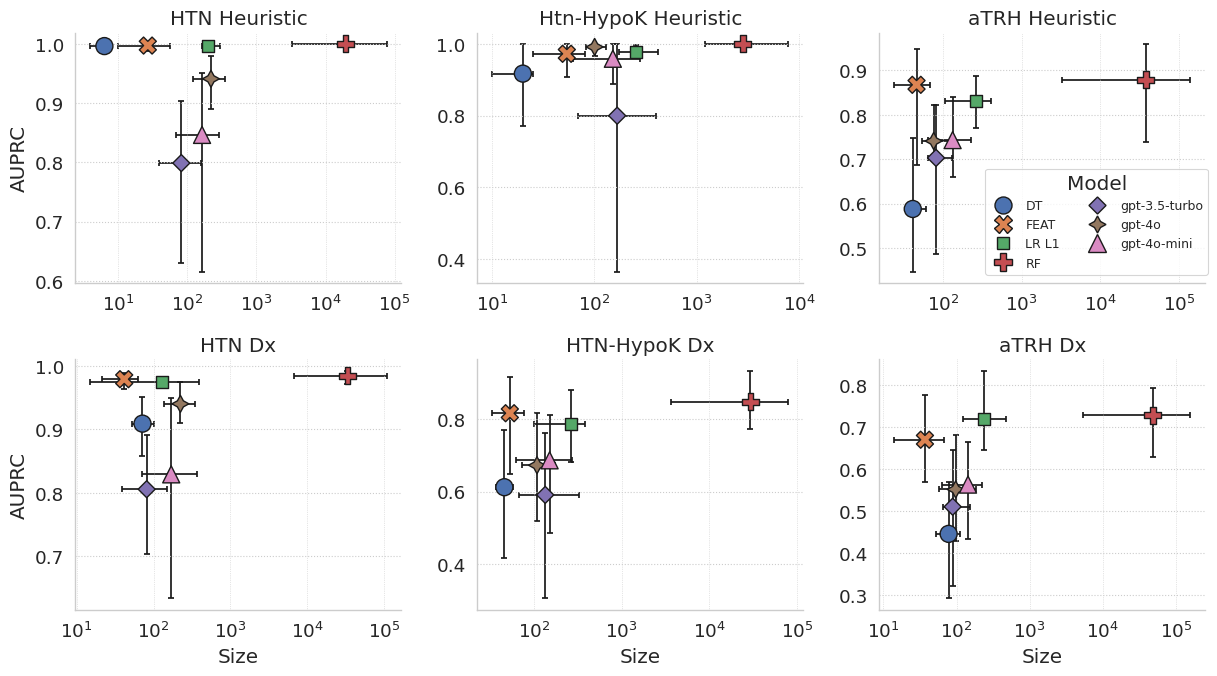

['gpt-3.5-turbo-iter' 'gpt-4o-iter' 'gpt-4o-mini-iter' 'DT' 'FEAT' 'LR L1'
 'RF']
Index(['target', 'Model', 'Roc auc score testmean', 'Roc auc score teststd',
       'Roc auc score testlower_ci', 'Roc auc score testupper_ci', 'Sizemean',
       'Sizestd', 'Sizelower_ci', 'Sizeupper_ci'],
      dtype='object')


/tmp/ipykernel_791296/2092243245.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]


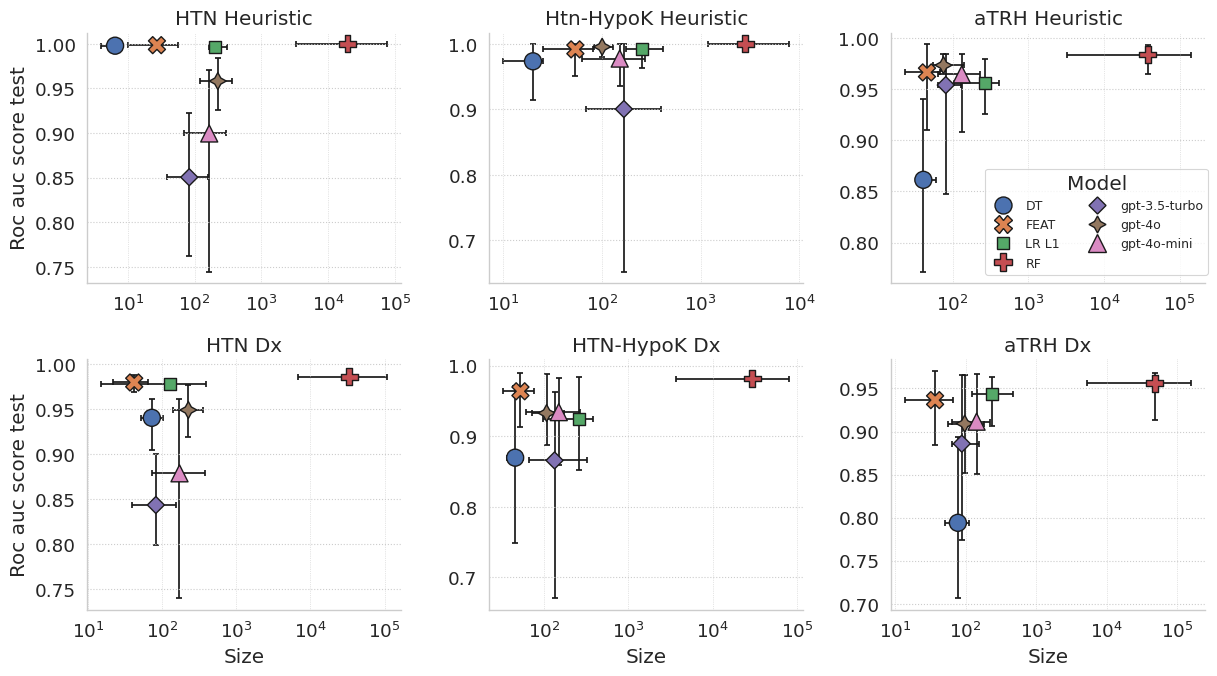

In [8]:
# Copying Fig.3 from paper "A flexible symbolic regression method for constructing
# interpretable clinical prediction models"

palette = sns.color_palette("hls", 7) # ['#374aa3', '#cc6666', '#6688d0', '#ffcccc', '#336699', '#99ccff']
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.5
)

for yaxis in ['average_precision_score_test', 'roc_auc_score_test']:
    data = (
        results_df[
            (results_df['model'].isin(['DT','FEAT','LR L1','RF']))
            | 
            (
                (results_df['prompt_richness']==True)
                & ( (results_df['icd_only']==True)
                  & (results_df['model'].str.contains('iter')))
            )
        ]
    )

    print(data.model.unique())
    data['Strategy'] = ['SEDI' if 'iter' in v else 'Zero Shot' for v in data['model'].values]
    #data = data[data['Strategy']=='SEDI']

    data = data.rename(columns={yaxis: yaxis.replace('_', ' ').capitalize(), 'model':'Model', 'size':'Size'})
    yaxis = yaxis.replace('_', ' ').capitalize()
    
    data['Model'] = data['Model'].apply(lambda x: x.replace('-iter',''))

    def lower_ci(x): return x.quantile(0.05)
    def upper_ci(x): return x.quantile(0.95)

    data = data.groupby(['target', 'Model'])[[yaxis, 'Size']].agg(['mean', 'std', lower_ci, upper_ci]).reset_index()

    model_order = [o for o in order if o in data.Model.unique()]
    data.columns = list(map(''.join, data.columns.values))

    print(data.columns)

    # phenotypes_order =  ['Resistant HTN Heuristic', 'HTN Heuristic', 'Htn-Hypokalemia Heuristic', 
    #                      'Resistant HTN Diagnosis', 'HTN Diagnosis', 'HTN-Hypokalemia Diagnosis']

    phenotypes_order =  ['HTN Heuristic', 'Htn-Hypokalemia Heuristic', 'Resistant HTN Heuristic',
                         'HTN Diagnosis', 'HTN-Hypokalemia Diagnosis', 'Resistant HTN Diagnosis']

    g = sns.relplot(
        data=data,
        x="Sizemean", y=f"{yaxis}mean", aspect=1, height=3.5, 
        col="target", col_wrap=3, col_order=phenotypes_order,
        kind="scatter",
        hue='Model', # hue_order=model_order,
        style ='Model', # style_order=model_order,
        linewidth=1.0, s=150, alpha=1.0, # sharey=False
        edgecolor='k', 
        facet_kws={'sharey': False, 'sharex': False}
    )

    for (title, plot_ax) in g._axes_dict.items():
        plot_ax.set_title(
            title
            .replace('Diagnosis','Dx')
            .replace('Resistant HTN', 'aTRH')
            .replace('Hypokalemia','HypoK')
        )
        plot_ax.grid(which='major', axis='y', linewidth=.8, ls=':', zorder=-9999)
        plot_ax.grid(which='major', axis='x', linewidth=.5, ls=':', zorder=-9999)
    
        plot_ax.set_xlabel(plot_ax.get_xlabel().replace('mean', '') if plot_ax.get_xlabel() else '')
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('mean', '') if plot_ax.get_ylabel() else '')
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('Average precision score test', 'AUPRC') if plot_ax.get_ylabel() else '')

        # for tick in plot_ax.get_xticklabels():
        #     tick.set(rotation=30, ha='center', va='top', ma='right')

        mask = data['target'] == title
        x_data = data[mask]['Sizemean']
        x_std = data[mask]['Sizestd']
        x_lower = data[mask]["Sizelower_ci"]
        x_upper = data[mask]["Sizeupper_ci"]

        y_data = data[mask][f"{yaxis}mean"]
        y_std = data[mask][f"{yaxis}std"]
        y_lower = data[mask][f"{yaxis}lower_ci"]
        y_upper = data[mask][f"{yaxis}upper_ci"]
        
        for i, (x, x_std, x_l, x_u, y, y_std, y_l, y_u) in enumerate(zip(
            x_data, x_std, x_lower, x_upper, y_data, y_std, y_lower, y_upper)):

            plot_ax.errorbar(
                x=x, 
                y=y, 
                # xerr=x_std,
                # yerr=y_std,
                xerr=[[abs(x - x_l)], [abs(x - x_u)]],
                yerr=[[abs(y - y_l)], [abs(y - y_u)]],
                fmt='none',  # No marker, just error bars
                color='k', #, palette[i],
                capsize=2,
                elinewidth=1.25,
                capthick=1.25,
                alpha=1.0,
                zorder=-999
            )

    g.set(xscale="log")


    sns.move_legend(g, "upper left", bbox_to_anchor=(0.8, 0.75), ncol=2, fontsize=9, frameon=True)
    plt.tight_layout()
    plt.savefig(f"{paper_dir}/pareto_grouped_{yaxis}.pdf")
    plt.savefig(f"{paper_dir}/pareto_grouped_{yaxis}.png")
    plt.show()

In [ ]:
# Copying Fig.3 from paper "A flexible symbolic regression method for constructing
# interpretable clinical prediction models"
for yaxis in ['average_precision_score_test', 'roc_auc_score_test']:
    g = sns.relplot(
        data=results_df,
        x="size", y=yaxis, col="target", 
        col_order = dnames_nice,
        kind="scatter",
        style='model', markers=marker_choice,
        hue = "model", hue_order=order, col_wrap=3,
        linewidth=0.5, s=100
    )
    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='y', linewidth=.5)
        plot_ax.grid(which='major', axis='x', linewidth=.5)
        
        for tick in plot_ax.get_xticklabels():
            tick.set(rotation=30, ha='center', va='top', ma='right')

    g.set(xscale="log")

    plt.savefig(f"{paper_dir}/fig3_{yaxis}.pdf")
    plt.savefig(f"{paper_dir}/fig3_{yaxis}.png")
    plt.show()

: 

In [ ]:
def parse(pred):
    pred = pred.replace('\n','')
    pred = pred.replace('[','')
    pred = pred.replace(']','')
    pred = list(map(float,pred.split()))
    return pred

def prc_values(y,y_pred_proba):
    precision, recall, prcthresholds = precision_recall_curve(y, y_pred_proba, pos_label=1)
    precision[-1] = np.max(precision[:-1])
    s = np.argsort(recall)
    precision = precision[s]
    recall = recall[s]
    mean_recall = np.linspace(0.0, 1, 21)
    precision = interp(mean_recall, recall, precision)
    return mean_recall, precision

def roc_values(y,y_pred_proba):
    fpr,tpr, rocthresholds = roc_curve(y, y_pred_proba, pos_label=1)
    roc = pd.DataFrame(list(zip(fpr,tpr, rocthresholds)), columns =['fpr','tpr','thresholds']) 
    roc = roc.sort_values(by='fpr')
    tpr = roc['tpr']
    fpr = roc['fpr']
    mean_fpr = np.linspace(0, 1, 21)
    tpr = interp(mean_fpr, fpr, tpr)
    return mean_fpr, tpr


: 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Filtering (just for this plot)
# results_df = results_df[results_df['target'].isin(['HTN Heuristic', 'HTN Diagnosis'])]

# Calculating rocauc and auprc
spacing, fontsize = 3, 14
for target, perf_t in results_df.groupby('target'):
    # if target == 'Resistant HTN Diagnosis': continue
    # if target == 'HTN-Hypokalemia Diagnosis': continue

    target_new = dnames_to_ugly[target]
    print(target, target_new, f"(shape {perf_t.shape})", sep=",")

#     ax = fig.add_subplot(2,3, i) 
    fig = plt.figure(figsize=(12,6))
    # axis for PR curve
    ax1 = fig.add_subplot(1,2,1)
    # axis for ROC curve
    ax2 = fig.add_subplot(1,2,2)
    
    i = 1
    for m, model_nice in enumerate([o for o in order if o in perf_t.model.unique()]):
        # model = nice_to_ugly[model_nice]
        perf_t_m = perf_t.loc[perf_t.model==model_nice] 
        
        print(f'- graphing {model_nice} - shape {perf_t_m.shape}')

        mean_run_precisions = []
        mean_run_tprs = []
        if i == 1 and target_new in heuristics.keys():
            mean_run_precision_h = []
            mean_run_recall_h = []
            mean_run_fpr_h = []
            mean_run_tpr_h = []

        for RunID, perf_t_m_id in perf_t_m.groupby('RunID'):
            precisions = []
            tprs = []
            precisions_h = []
            recalls_h = []
            fprs_h = []
            tprs_h = []

            for fold, perf_t_m_id_f in perf_t_m_id.groupby('fold'):

                #True labels
                df = pd.read_csv('../data/Dataset' + str(RunID) + '/' +
                                 target_new + '/' + target_new + fold +
                                 'Test.csv')
                                 
                y = df[targets_rev[target_new]].values
                
                for random_state, perf_t_m_id_f_r in perf_t_m_id_f.groupby('random_state'):
                    print(" -", RunID, fold, random_state)

                    # handle the heuristic
                    if i == 1 and target_new in heuristics.keys():
                        y_heuristic = df[heuristics[target_new]].values

                        # print('y_heuristic:', y_heuristic)

                        precision_h = np.sum((y==1) & (y_heuristic==1))/np.sum(y_heuristic==1)
                        recall_h = np.sum((y==1) & (y_heuristic==1))/np.sum(y==1)

                        # print('precision_h:',precision_h)
                        # print('recall_h:',recall_h)
                        
                        precisions_h.append(precision_h)
                        recalls_h.append(recall_h)

                        fpr_h = np.sum((y==0) & (y_heuristic==1))/np.sum(y==0) 
                        tpr_h = recall_h

                        # print('fpr_h:',fpr_h)
                        # print('tpr_h:',tpr_h)
                    
                        fprs_h.append(fpr_h)
                        tprs_h.append(tpr_h)

                        heuristic=False

                    # print('y:',len(y))

                    #Predicted probabilities
                    assert(len(perf_t_m_id_f_r)==1)

                    # print(perf_t_m_id_f_r['pred_proba'].values[0])
                    # print(type(perf_t_m_id_f_r['pred_proba'].values[0]))
                    # y_pred_proba = eval(perf_t_m_id_f_r['pred_proba'].values[0])
                    y_pred_proba = perf_t_m_id_f_r['pred_proba'].values[0]
                
                    # Precision / Recall
                    ####################
                    mean_recall, precision = prc_values(y,y_pred_proba)
                    precisions.append(precision)
                
                    # ROC
                    #####
                    mean_fpr, tpr = roc_values(y,y_pred_proba)
                    tprs.append(tpr)
                
                #mean_run_precisions: The mean of five fold precisions
                mean_run_precisions.append(np.mean(precisions, axis=0))
                #mean_run_tprs: The mean of five fold tprs
                mean_run_tprs.append(np.mean(tprs, axis=0))
                if i == 1 and target_new in heuristics.keys():
                    mean_run_precision_h.append(np.mean(precisions_h, axis=0))
                    mean_run_recall_h.append(np.mean(recalls_h, axis=0))
                    mean_run_fpr_h.append(np.mean(fprs_h, axis=0))
                    mean_run_tpr_h.append(np.mean(tprs_h, axis=0))

        #mean_precisions: The mean of mean_run_precisions over 50 iterations
        mean_precisions = np.mean(mean_run_precisions, axis=0)
        #mean_tprs: The mean of mean_run_tprs over 50 iterations
        mean_tprs = np.mean(mean_run_tprs, axis=0)
        
#         plt.figure(target_new, figsize=(10, 6))
        # Precision/Recall plot 
        ax1.plot(mean_recall, mean_precisions, 
                 alpha=1,
                 label=model_nice,
                 marker = marker_choice[model_nice], 
                 markevery=spacing)
        # ROC plot
        #####
        ax2.plot(mean_fpr, mean_tprs, 
                 alpha=1,
                 label=model_nice,
#                  marker = markers[m], 
                 marker = marker_choice[model_nice], 
                 markevery=spacing)
        ax2.plot([0,1],[0,1],'--k',label=None)
        i+=1
            
    # heuristic performance
#     print('mean_run_precision_h:',mean_run_precision_h)
#     print('mean_run_recall_h:',mean_run_recall_h)
#     print('mean_run_fpr_h:',mean_run_fpr_h)
#     print('mean_run_tpr_h:',mean_run_tpr_h)
    mean_recall_h = np.mean(mean_run_recall_h, axis=0)
    mean_precision_h = np.mean(mean_run_precision_h, axis=0)
    mean_fpr_h = np.mean(mean_run_fpr_h, axis=0)
    mean_tpr_h = np.mean(mean_run_tpr_h, axis=0)
    print(mean_recall_h, mean_precision_h, mean_fpr_h, mean_tpr_h)
    # plot heuristic
    ax1.plot(mean_recall_h,
             mean_precision_h,
             'Xk',
             label='Heuristic',
            ) 
    # plot heuristic
    ax2.plot(mean_fpr_h,
             mean_tpr_h,
             'Xk',
             label='Heuristic',
            ) 
    plt.suptitle(dnames_to_nice[target_new], fontsize=fontsize)
    ax1.set_xlabel("Recall (Sensitivity)", fontsize=fontsize)
    ax1.set_ylabel("Precision", fontsize=fontsize)
    ax2.set_xlabel("1 - Specificity", fontsize=fontsize)
    ax2.set_ylabel("Sensitivity", fontsize=fontsize)
#     if i in [1,4]:
#         plt.xlabel("Recall (Sensitivity)")
#     if i > 3:
#         plt.ylabel("Precision (PPV)")
#     else:
#         plt.xticks([])
#     if i == 6:        
#         plt.legend()
    
#     i += 1
    plt.legend(loc='best')
    plt.tight_layout()
    sns.despine()
    ax1.grid()
    ax2.grid()
    for filetype in ['.svg','.png','.pdf']:
        plt.savefig(f'{paper_dir}/{target_new}_PRC_ROC{filetype}', dpi=400)

# plt.show() 

: 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Calculating rocauc and auprc
spacing, fontsize = 3, 14
for target, perf_t in results_df.groupby('target'):
    target_new = dnames_to_ugly[target]
    print(target, target_new, f"(shape {perf_t.shape})", sep=",")

    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    i = 1
    for m, model_nice in enumerate([o for o in order if o in perf_t.model.unique()]):
        perf_t_m = perf_t.loc[perf_t.model==model_nice] 
        
        print(f'- graphing {model_nice} - shape {perf_t_m.shape}')

        mean_run_precisions = []
        mean_run_tprs = []
        if i == 1 and target_new in heuristics.keys():
            mean_run_precision_h = []
            mean_run_recall_h = []
            mean_run_fpr_h = []
            mean_run_tpr_h = []

        for RunID, perf_t_m_id in perf_t_m.groupby('RunID'):
            precisions = []
            tprs = []
            precisions_h = []
            recalls_h = []
            fprs_h = []
            tprs_h = []

            for fold, perf_t_m_id_f in perf_t_m_id.groupby('fold'):

                #True labels
                df = pd.read_csv('../data/Dataset' + str(RunID) + '/' +
                                 target_new + '/' + target_new + fold +
                                 'Test.csv')
                                 
                y = df[targets_rev[target_new]].values
                
                for random_state, perf_t_m_id_f_r in perf_t_m_id_f.groupby('random_state'):
                    print(" -", RunID, fold, random_state)

                    # handle the heuristic
                    if i == 1 and target_new in heuristics.keys():
                        y_heuristic = df[heuristics[target_new]].values

                        # print('y_heuristic:', y_heuristic)

                        precision_h = np.sum((y==1) & (y_heuristic==1))/np.sum(y_heuristic==1)
                        recall_h = np.sum((y==1) & (y_heuristic==1))/np.sum(y==1)

                        # print('precision_h:',precision_h)
                        # print('recall_h:',recall_h)
                        
                        precisions_h.append(precision_h)
                        recalls_h.append(recall_h)

                        fpr_h = np.sum((y==0) & (y_heuristic==1))/np.sum(y==0) 
                        tpr_h = recall_h

                        # print('fpr_h:',fpr_h)
                        # print('tpr_h:',tpr_h)
                    
                        fprs_h.append(fpr_h)
                        tprs_h.append(tpr_h)

                        heuristic=False

                    # print('y:',len(y))

                    #Predicted probabilities
                    assert(len(perf_t_m_id_f_r)==1)

                    # print(perf_t_m_id_f_r['pred_proba'].values[0])
                    # print(type(perf_t_m_id_f_r['pred_proba'].values[0]))
                    # y_pred_proba = eval(perf_t_m_id_f_r['pred_proba'].values[0])
                    y_pred_proba = perf_t_m_id_f_r['pred_proba'].values[0]
                
                    # Precision / Recall
                    ####################
                    mean_recall, precision = prc_values(y,y_pred_proba)
                    precisions.append(precision)
                
                    # ROC
                    #####
                    mean_fpr, tpr = roc_values(y,y_pred_proba)
                    tprs.append(tpr)
                
                mean_run_precisions.append(np.mean(precisions, axis=0))
                mean_run_tprs.append(np.mean(tprs, axis=0))

                if i == 1 and target_new in heuristics.keys():
                    mean_run_precision_h.append(np.mean(precisions_h, axis=0))
                    mean_run_recall_h.append(np.mean(recalls_h, axis=0))
                    mean_run_fpr_h.append(np.mean(fprs_h, axis=0))
                    mean_run_tpr_h.append(np.mean(tprs_h, axis=0))

        mean_run_precisions = np.array(mean_run_precisions)
        mean_run_tprs = np.array(mean_run_tprs)

        mean_precisions = np.mean(mean_run_precisions, axis=0)
        mean_tprs = np.mean(mean_run_tprs, axis=0)

        # Precision/Recall plot 
        best_run = np.argmax(np.sum(mean_run_precisions, axis=1))
        ax1.plot(mean_recall, mean_run_precisions[best_run], 
                 alpha=1,
                 label=model_nice,
                 marker = marker_choice[model_nice], 
                 markevery=spacing)
        
        # ROC plot
        best_run = np.argmax(np.sum(mean_run_tprs, axis=1))
        ax2.plot(mean_fpr, mean_run_tprs[best_run], 
                 alpha=1,
                 label=model_nice,
                 marker = marker_choice[model_nice], 
                 markevery=spacing)
        
        ax2.plot([0,1],[0,1],'--k',label=None)

        i+=1
            
    mean_recall_h = np.mean(mean_run_recall_h, axis=0)
    mean_precision_h = np.mean(mean_run_precision_h, axis=0)
    mean_fpr_h = np.mean(mean_run_fpr_h, axis=0)
    mean_tpr_h = np.mean(mean_run_tpr_h, axis=0)

    print(mean_recall_h, mean_precision_h, mean_fpr_h, mean_tpr_h)

    # plot heuristic
    ax1.plot(mean_recall_h,
             mean_precision_h,
             'Xk',
             label='Heuristic',
            ) 
    # plot heuristic
    ax2.plot(mean_fpr_h,
             mean_tpr_h,
             'Xk',
             label='Heuristic',
            ) 
    
    plt.suptitle(dnames_to_nice[target_new], fontsize=fontsize)
    ax1.set_xlabel("Recall (Sensitivity)", fontsize=fontsize)
    ax1.set_ylabel("Precision", fontsize=fontsize)
    ax2.set_xlabel("1 - Specificity", fontsize=fontsize)
    ax2.set_ylabel("Sensitivity", fontsize=fontsize)
    
    plt.legend(loc='best')
    plt.tight_layout()
    sns.despine()
    ax1.grid()
    ax2.grid()
    for filetype in ['.svg','.png','.pdf']:
        plt.savefig(f'{paper_dir}/{target_new}_PRC_ROC_BEST_MODEL{filetype}', dpi=400)

: 

In [ ]:
# # Copying Fig.2 from paper "A flexible symbolic regression method for constructing
# # interpretable clinical prediction models"

# for stat_comparisons in [False, True]:
#     for yaxis in [
#         'average_precision_score_test', 
#         'roc_auc_score_test', 
#         'accuracy_score_test', 
#         'size'
#     ]:
#         data = results_df_melted[results_df_melted['variable']==yaxis].dropna()
                    
#         yaxis = yaxis.replace('_', ' ').capitalize()

#         data = data.rename(columns={'value': yaxis, 'model':'Model'})
#         data[yaxis] = data[yaxis].astype(float)

#         print(data.random_state.unique())
#         display(data)

#         g = sns.catplot(
#             data=data,
#             x="Model", y=yaxis, col="target",
#             order=order, col_wrap=3, col_order=phenotypes_order,
#             aspect= 1 if stat_comparisons else 0.825,
#             height= 5 if stat_comparisons else 3.25,
#             estimator=np.mean, sharey=not stat_comparisons,
#             kind="box", **boxplot_kwargs
#         )
#         g.refline(x=5.5, color='k', lw=0.5, ls='--', zorder=0)
        
#         for (title, xaxis) in g._axes_dict.items():
#             xaxis.set_title(title)
#             xaxis.grid(which='major', axis='y', linewidth=.8)
#             xaxis.grid(which='major', axis='x', linewidth=.5)
            
#             for tick in xaxis.get_xticklabels():            
#                 if stat_comparisons:
#                     tick.set(rotation=45, ha='right', va='top', ma='center')
#                 else:
#                     tick.set(rotation=90, ha='right', va='top', ma='center')

#             if yaxis=='Size':
#                 xaxis.set_yscale('log')

#             # All vs baseline
#             llms = [
#                 'gpt-4o-mini',
#                 'gpt-4o-mini-iter',
#                 'gpt-4o',
#                 'gpt-4o-iter',
#                 'gpt-4-turbo',
#                 'gpt-4-turbo-iter',
#             ]
#             pairs = (
#                 # list(itertools.product(llms, llms)) +
#                 [(llm, 'FEAT') for llm in llms ]
#             )

#             if stat_comparisons:
#                 try:
#                     annotator = Annotator(
#                         xaxis, pairs, data=data[(data['target']==title)][
#                             ['Model', 'target',	yaxis]
#                         ],
#                         x='Model', y=yaxis,
#                         order=order)
#                     annotator.reset_configuration()
#                     annotator.configure(test="Mann-Whitney", hide_non_significant=True, text_format='simple',
#                                         comparisons_correction="holm", verbose=0) # , text_offset=-3
                    
#                     # Calculate and annotate
#                     annotator.apply_and_annotate()
#                 except Exception as e:
#                     print(f"failed to add statsannotation with dataset {title}. Except {e}")

#         g.map_dataframe(sns.stripplot, y=yaxis, dodge=True, 
#                     x="Model", order=order, size=2, color='k',
#                     linewidth=0.5, alpha=0.25)
    
#         plt.tight_layout()
#         plt.savefig(f"{paper_dir}/fig2_{yaxis}{'_stat_comparisons' if stat_comparisons else ''}.pdf")
#         plt.savefig(f"{paper_dir}/fig2_{yaxis}{'_stat_comparisons' if stat_comparisons else ''}.png")
#         plt.show()

: 